In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Requirement already up-to-date: pip in c:\users\wayne\appdata\local\programs\python\python36\lib\site-packages (20.2.4)
Note: you may need to restart the kernel to use updated packages.


In [3]:
def evaluate_classifier(clf, data, target, split_ratio):
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=split_ratio, random_state=0)
    clf.fit(trainX, trainY)
    return clf.score(testX,testY)

In [4]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
target = train["label"]
train = train.drop("label",1)

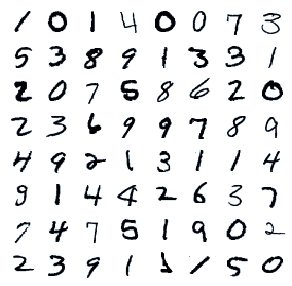

In [6]:
figure(figsize(5,5))
for digit_num in range(0,64):
    subplot(8,8,digit_num+1)
    grid_data = train.iloc[digit_num].to_numpy().reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "bone_r")
    xticks([])
    yticks([])

In [7]:
# check performance of random forest classifier, as function of number of estimators 
# here we only take 1000 data points to train

n_estimators_array = np.array([1,5,10,50,100,200,500])
n_samples = 10
n_grid = len(n_estimators_array)
score_array_mu =np.zeros(n_grid)
score_array_sigma = np.zeros(n_grid)
j=0
for n_estimators in n_estimators_array:
    score_array=np.zeros(n_samples)
    for i in range(0,n_samples):
        clf = RandomForestClassifier(n_estimators = n_estimators, n_jobs=1, criterion="gini")
        score_array[i] = evaluate_classifier(clf, train.iloc[0:1000], target.iloc[0:1000], 0.8)
    score_array_mu[j], score_array_sigma[j] = mean(score_array), std(score_array)
    j=j+1

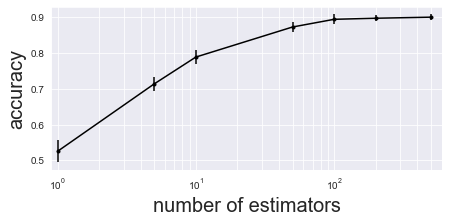

In [8]:
# it looks like the performace saturates around 50-100 estimators

figure(figsize(7,3))
errorbar(n_estimators_array, score_array_mu, yerr=score_array_sigma, fmt='k.-')
xscale("log")
xlabel("number of estimators",size = 20)
ylabel("accuracy",size = 20)
xlim(0.9,600)
grid(which="both")

Feature ranking:
1. feature 409 (0.010204)
2. feature 378 (0.008637)
3. feature 405 (0.007908)
4. feature 406 (0.007806)
5. feature 433 (0.007376)
6. feature 155 (0.007097)
7. feature 461 (0.006857)
8. feature 377 (0.006676)
9. feature 437 (0.006562)
10. feature 350 (0.006491)


Text(0, 0.5, 'importance')

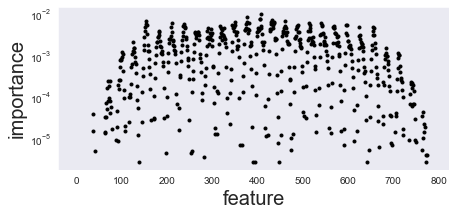

In [9]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(0,10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances

figure(figsize(7,3))
plot(indices[:],importances[indices[:]],'k.')
yscale("log")
xlabel("feature",size=20)
ylabel("importance",size=20)

Text(0, 0.5, 'PC2')

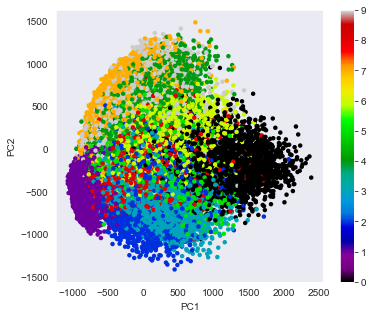

In [10]:
pca = PCA(n_components=2)
pca.fit(train)
transform = pca.transform(train)

figure(figsize(6,5))
plt.scatter(transform[:,0],transform[:,1], s=20, c = target, cmap = "nipy_spectral", edgecolor = "None")
plt.colorbar()
clim(0,9)

xlabel("PC1")
ylabel("PC2")

In [11]:
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    vr[i] = sum(pca.explained_variance_ratio_)
    i=i+1    

Text(0, 0.5, 'variance ratio')

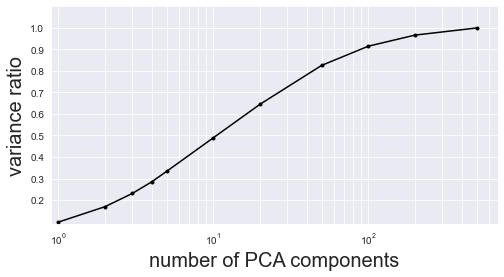

In [12]:
figure(figsize(8,4))
plot(n_components_array,vr,'k.-')
xscale("log")
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which="both")
xlabel("number of PCA components",size=20)
ylabel("variance ratio",size=20)

In [13]:
clf = KNeighborsClassifier()
n_components_array=([1,2,3,4,5,10,20,50,100,200,500])
score_array = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca = PCA(n_components=n_components)
    pca.fit(train)
    transform = pca.transform(train.iloc[0:1000])
    score_array[i] = evaluate_classifier(clf, transform, target.iloc[0:1000], 0.8)
    i=i+1

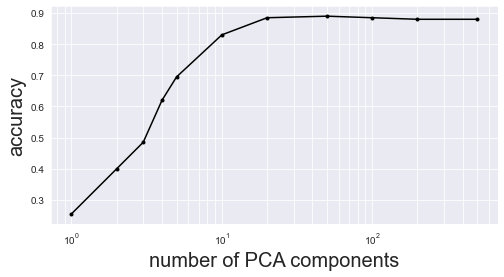

In [14]:
figure(figsize(8,4))
plot(n_components_array,score_array,'k.-')
xscale('log')
xlabel("number of PCA components", size=20)
ylabel("accuracy", size=20)
grid(which="both")

In [17]:
pca = PCA(n_components=50)
pca.fit(train)
transform_train = pca.transform(train)
transform_test = pca.transform(test)

clf = KNeighborsClassifier()
clf.fit(transform_train, target)
results=clf.predict(transform_test)

# prepare submit file

np.savetxt('results(pca).csv', 
           np.c_[range(1,len(test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

In [18]:
# random forest classification

clf = RandomForestClassifier(n_estimators = 100, n_jobs=1, criterion="gini")
clf.fit(train, target)
results=clf.predict(test)

# prepare submit file

np.savetxt('results(random forest).csv', 
           np.c_[range(1,len(test)+1),results], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')